In [1]:
#install.packages('randomForest')
library(readxl)
library(randomForest)
library(tidyverse)
#install.packages('dplyr')
library(dplyr)
library(Rcpp)


library(rpart)# Popular decision tree algorithm
#install.packages('rattle')
library(rattle)# Fancy tree plot
library(rpart.plot)# Enhanced tree plots
library(RColorBrewer)# Color selection for fancy tree plot
library(party) # Alternative decision tree algorithm
#install.packages('partykit')
library(partykit)# Convert rpart object to BinaryTree

#install.packages('tree')
library(tree)
#install.packages('multcomp')
library(multcomp)
#install.packages('party')


#install.packages('Metrics')
library(Metrics)
#install.packages('reprtree')
#devtools::install_github("MI2DataLab/randomForestExplainer")
#install.packages('randomForestExplainer')
library(randomForestExplainer)
#install.packages("scales")
library(scales)
#update.packages()
#install.packages("packagename")
require(foreign)
require(nnet)
require(ggplot2)
require(reshape2)
#install.packages("stats4")
#install.packages("splines")
library(stats4) #Load package stats
library(splines) #Load package splines
#To load package VGAM, need to load package stats4 and splines.
#install.packages("VGAM")
library(VGAM) #Load package VGAM


#install.packages("psych")
#install.packages("PerformanceAnalytics")
library(corrplot)
library(PerformanceAnalytics)
library(psych)

library(data.table)
library(writexl)



Warning message:
"package 'randomForest' was built under R version 4.0.3"
randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.

Warning message:
"package 'tidyverse' was built under R version 4.0.3"
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.6     v dplyr   1.0.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

Warning message:
"package 'ggplot2' was built under R version 4.0.3"
Warning message:
"package 'tibble' was built under R version 4.0.3"
Warning message:
"package 'dplyr' was built under R version 4.0.3"
Warning message:
"package 'forcats' was built under R version 4.0.3"
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::combine()  masks randomForest::combine()
x dplyr::filter()   masks stats::filter()
x dplyr::lag()      masks s

# FA (weighted) Classifcation

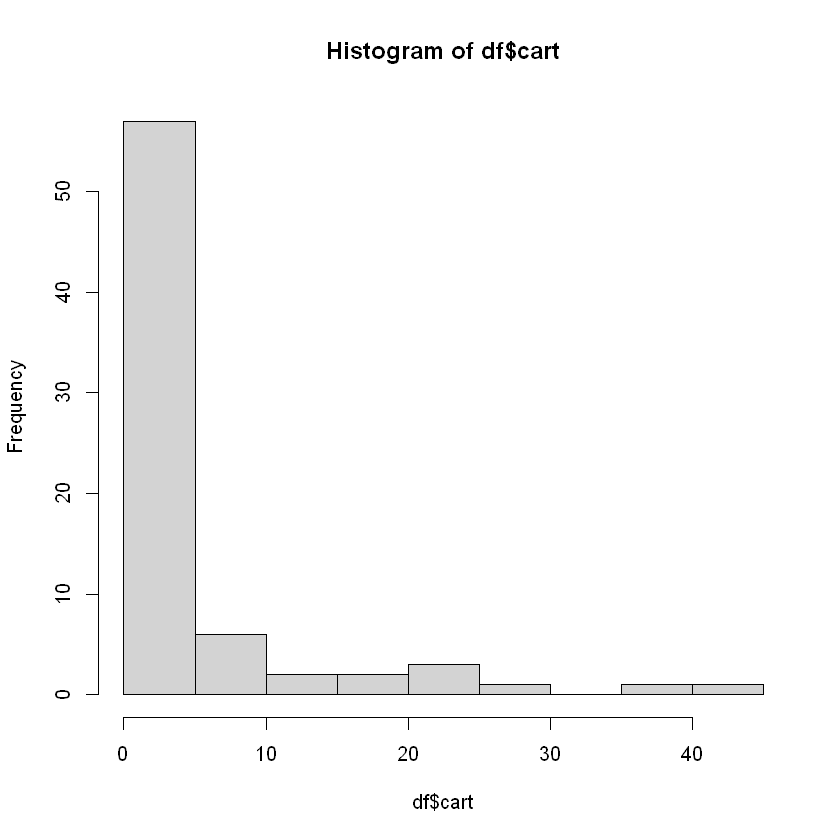

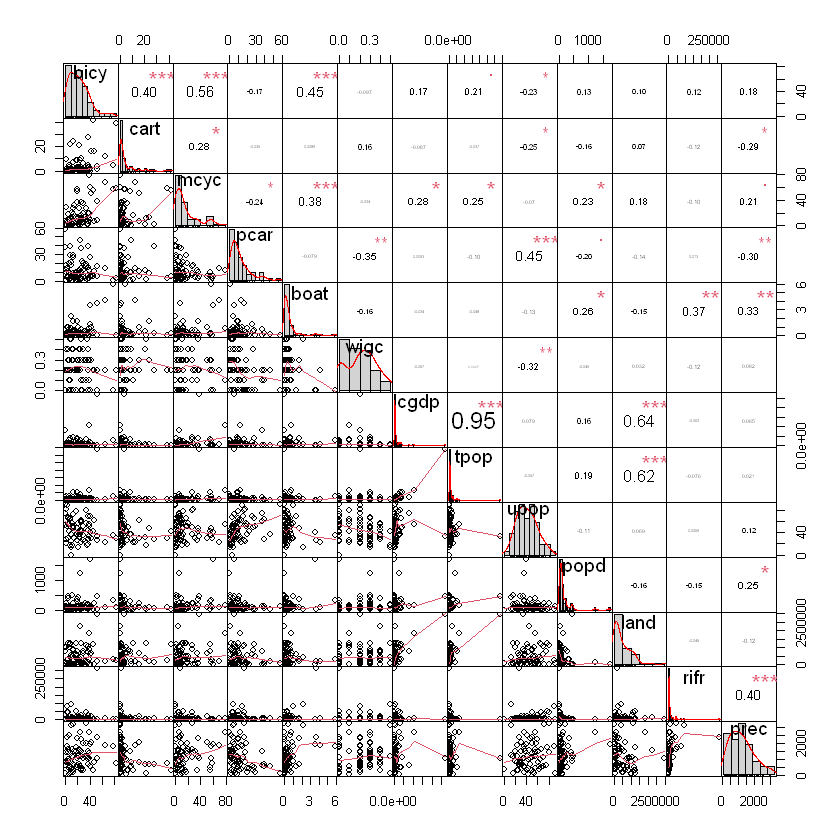

In [2]:
df.wa = read_excel( "../../results/df-water-access.xlsx" ,sheet=1)
df.exp =read_excel("../../results/df-water-explore.xlsx" ,sheet=1)
df.cluster = read_excel("../../results/df-fa-seven-cluster-rank.xlsx" ,sheet=1)
df.wb = read_excel("../../results/df-wb.xlsx" ,sheet=1 )
df.exp$clusters <- as.factor(df.cluster$clusters)
df <- merge(x = df.exp,
              y = df.wb,
              by = c("Country"))

df <- df[, c(1:13, 17,21)]

#scaling the world bank data similar to DHS aggregation out of 100
df.wb <- df[,c(9:15)]
df.wb <- data.frame(lapply(df.wb, function(x) scale(x, center = FALSE, scale = max(x, na.rm = TRUE)/100)))
df.scale <- cbind(df, df.wb)
df.scale <- df.scale[,c(1:8,15:21)]


df.a <- df[, c(1:6,8)]
hist(df$cart)

explnatory <- df[,c(2:7, 9:15)]
chart.Correlation(explnatory, histogram=TRUE, pch=19 , tl.cex = .7 )
                           


In [3]:
# ""Off-premise", "Market", "Piping"
df <- df%>%
  mutate(clusters=case_when(
    .$clusters=="1" ~ "Off-premise",
    .$clusters=="2" ~ "Market",
    .$clusters=="3" ~ "Piping",
      ))

df.scale <- df.scale%>%
  mutate(clusters=case_when(
    .$clusters=="1" ~ "Off-premise",
    .$clusters=="2" ~ "Market",
    .$clusters=="3" ~ "Piping",
      ))


In [4]:
df$clusters <- as.factor(df$clusters)
df.scale$clusters <- as.factor(df.scale$clusters)
write_xlsx(df , '../../results/class.xlsx')
write_xlsx(df.scale , '../../results/class-scale.xlsx')
head(df)

,Country,bicy,cart,mcyc,pcar,boat,wigc,clusters,cgdp,tpop,upop,popd,land,rifr,prec
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Afghanistan,30.0,5.8,35.2,11.8,0.0,0.1,Off-premise,18353881130,37172386,25.495,56.93776,652860,1299.0269,327
2,Albania,26.4,3.2,9.6,37.0,0.7,0.1,Market,15147020535,2866376,60.319,104.61226,27400,9361.5460,1485
3,Angola,4.6,1.3,17.8,10.9,0.4,0.3,Off-premise,101353230785,30809762,65.514,24.71305,1246700,4963.6533,1010
4,Armenia,8.6,0.4,0.2,39.2,0.3,0.1,Piping,12457941907,2951776,63.149,103.68022,28470,2329.1833,562
5,Azerbaijan,6.9,3.3,1.1,20.4,0.1,0.0,Piping,47112941176,9939771,55.680,120.23432,82670,823.5207,447
6,Bangladesh,25.1,0.0,6.4,0.8,0.0,0.3,Market,274039092455,161356039,36.632,1239.57931,130170,657.6039,2666


# Tree

In [29]:
# Make big tree
form <- as.formula(clusters ~ . - Country)
tree.fwa <- rpart(form,data=df,control=rpart.control(minsplit=4,cp=0.01, xval = nrow(df), maxsurrogate = 0, minbucket = 4 )
                 )

#par(mar=c(1,1,1,1))

png(
  "cp.png",
  width     = 5,
  height    = 5,
  units     = "in",
  res       = 700,
  #pointsize = 6
)

#plot(tree.fwa)# Will make a mess of the plot
#text(tree.fwa)

plotcp(tree.fwa)

dev.off()

printcp(tree.fwa)

#summary(tree.fwa) 
#prp(tree.fwa)# Will plot the tree
#prp(tree.fwa,varlen=4)# Shorten variable names

png 
  2


Classification tree:
rpart(formula = form, data = df, control = rpart.control(minsplit = 4, 
    cp = 0.01, xval = nrow(df), maxsurrogate = 0, minbucket = 4))

Variables actually used in tree construction:
[1] boat cgdp pcar popd prec

Root node error: 36/73 = 0.49315

n= 73 

        CP nsplit rel error  xerror    xstd
1 0.388889      0   1.00000 1.00000 0.11866
2 0.138889      1   0.61111 0.80556 0.11613
3 0.083333      2   0.47222 0.75000 0.11458
4 0.055556      3   0.38889 0.72222 0.11365
5 0.027778      4   0.33333 0.61111 0.10890
6 0.010000      6   0.27778 0.61111 0.10890


ERROR: Error in legend(x = x, y = y, legend = legend, col = 0, xpd = NA, bty = "n", : argument 8 matches multiple formal arguments


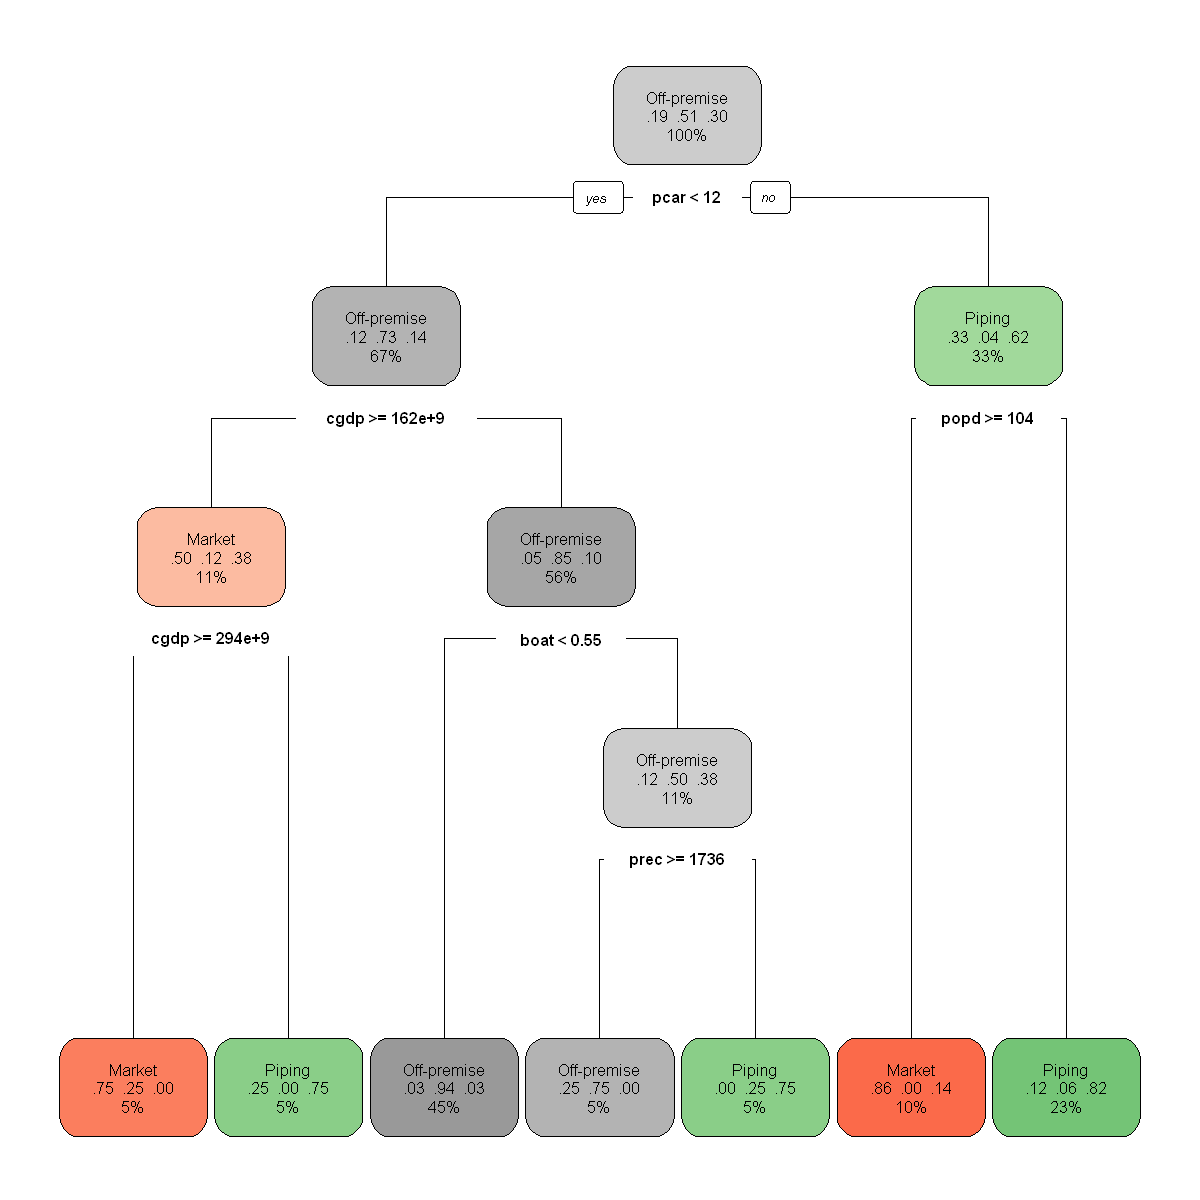

In [6]:
#size of the plot 
options(repr.plot.width=10, repr.plot.height=10)
par(mar = c(1,1,1,1))
par(cex=1)

#Interatively prune the tree
tree.pru <- prune(tree.fwa, cp=0.017) # interactively trim the tree
#prp(tree.pru) # display the new tree
rpart.plot(tree.pru)

In [24]:
par(mar=c(1,1,1,1))

png(
  "rpart.png",
  width     = 6,
  height    = 6,
  units     = "in",
  res       = 800,
  #pointsize = 6
)

fancyRpartPlot(tree.pru)


dev.off()

summary(tree.pru)

png 
  2

Call:
rpart(formula = form, data = df, control = rpart.control(minsplit = 4, 
    cp = 0.01, xval = nrow(df), maxsurrogate = 0, minbucket = 4))
  n= 73 

          CP nsplit rel error    xerror      xstd
1 0.38888889      0 1.0000000 1.0000000 0.1186556
2 0.13888889      1 0.6111111 0.8055556 0.1161345
3 0.08333333      2 0.4722222 0.7500000 0.1145768
4 0.05555556      3 0.3888889 0.7222222 0.1136506
5 0.02777778      4 0.3333333 0.6111111 0.1089012
6 0.01000000      6 0.2777778 0.6111111 0.1089012

Variable importance
pcar cgdp popd boat prec 
  43   25   18    7    6 

Node number 1: 73 observations,    complexity param=0.3888889
  predicted class=Off-premise  expected loss=0.4931507  P(node) =1
    class counts:    14    37    22
   probabilities: 0.192 0.507 0.301 
  left son=2 (49 obs) right son=3 (24 obs)
  Primary splits:
      pcar < 12.4         to the left,  improve=12.198510, (0 missing)
      wigc < 0.25         to the right, improve= 6.923826, (0 missing)
      cgdp < 1097

In [ ]:
prp(tree.fwa, snip=TRUE)

http://www.milbo.org/rpart-plot/prp.pdf
http://www.di.fc.ul.pt/~jpn/r/tree/tree.html

In [ ]:
tree.wa = tree(clusters ~ . - Country  , data = df.scale)
summary(tree.wa) 
plot(tree.wa)
text(tree.wa, pretty = 0 , cex=.8) 

In [ ]:
tree.wa = tree(clusters ~ . - Country  , data = df, mindev=0.01, )
summary(tree.wa) 
plot(tree.wa)
text(tree.wa, pretty = 0 , cex=.90) 

# Distributional prediction
my.prediction <- predict(tree.wa) # gives the probability for each class
head(my.prediction)

# Point prediction
# Let's translate the probability output to categorical output
maxidx <- function(arr) {
    return(which(arr == max(arr)))
}
idx <- apply(my.prediction, c(1), maxidx)
prediction <- c("Worst Water Source", "Better Water Source", "Best Water Source")[idx]
table(prediction, df.scale$clusters)

In [ ]:
plot(tree.wa)
text(tree.wa)

In [ ]:
pru.wa <- prune.tree(tree.wa, best = 6 )
summary(pru.wa)
plot(pru.wa)
text(pru.wa, pretty = 0)


# Random Forest

In [ ]:
rf.water = randomForest(clusters~. -Country, data = df , ntree= 200,mtry=12)
print(rf.water)

summary(rf.water)

#importance <- importance(rf.water, sort = TRUE)
#importance

# create an importance plot
varImpPlot(rf.water, sort=TRUE, n.var=min(30, nrow(rf.water$importance)),
           type=NULL, class=NULL, scale=TRUE )
#plot
plot(randomForest(clusters~. -Country, data = df ,ntree=200,  keep.forest=FALSE, mtry=5) )

The MeanDecreaseGini measures the Gini importance = how important the features are over all splits done in the tree/forest - whereas for each individual split the Gini importance indicates how much the Gini criterion = "unequality/heterogeneity" was reduced using this split.
mori, upop, pcar popd, mcyc important and contributed most to obtaining such splits, so they are considered more important.

# MULTINOMIAL LOGISTIC REGRESSION

In [ ]:
head(df)
with(df, table( df[,8]),)


In [ ]:
head(df)

# Fit the model
model <- nnet::multinom(clusters ~. -Country  , data = df)
# Summarize the model
summary(model)

#z values
z <- summary(model)$coefficients/summary(model)$standard.errors
z
# 2-tailed z test
p <- (1 - pnorm(abs(z), 0, 1)) * 2
p

## extract the coefficients from the model and exponentiate
exp(coef(model))

# Make predictions
predicted.classes <- model %>% predict(df)
head(predicted.classes)

head(pp <- fitted(model))
# Model accuracy
mean(predicted.classes == df$clusters)

fit.MLR <- vglm( clusters ~ bicy + cart + mcyc +
                pcar+boat+wigc+cgdp+tpop+upop+popd+land+rifr+prec ,
                family=multinomial, df)
summary(fit.MLR)


